In [5]:
import matplotlib.widgets
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import os
import scipy.stats
from IPython.display import display, clear_output
import ipywidgets as widgets

!jupyter serverextension enable voila --sys-prefix

source = pd.read_csv("meta/protein_quant_current_normalized.csv", low_memory=False)


def get_the_file(gene):
    
    # downloads the RNAseq file from the Broad website

    url = 'https://portals.broadinstitute.org/ccle/page?gene='+str(gene)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    for link in soup.findAll('a', attrs={'href': re.compile("RNA")}):
        url2 = 'https://portals.broadinstitute.org' + link.get('href')
    
    myfile = requests.get(url2)
    open(str(gene)+'.txt', 'wb').write(myfile.content)
    

def graphing(dataFrame, gene, parameter, colors):
    plt.figure()
    sns.set(rc={'figure.figsize':(10,10)})
    # Plots the datapoints parameter vs. gene expression
    a = sns.regplot(x=parameter, y=gene, data=dataFrame, color = colors)
    a.set_title('Correlation between ' + gene + ' and ' + parameter)
    display(a.figure)

def pval(dataF, gene, corr, par):
    if par == 'p':
        x = dataF[corr]
        y = dataF[gene]
        return scipy.stats.pearsonr(x, y)[1]
    elif par == 's':
        x = dataF[corr]
        y = dataF[gene]
        return scipy.stats.spearmanr(x, y)[1]

def NSCLC_expression(gene):
    from scipy import stats
    get_the_file(gene)
    
    #gene = str(file[:-4])
    
    # Extract NSCLC line names and put it in the list
    
    lines = open('meta/NSCLC_Panel.txt').read().splitlines()
    NSCLC_Lines = []
    for i in lines:
        NSCLC_Lines.append(i)
        
    # Filters data by NSCLC line panel
    
    NSCLC_exp = {}
    for d in csv.DictReader(open(gene +'.txt'), delimiter='\t'):
        for i in NSCLC_Lines:
             NSCLC_exp[i] = d[i]
   
    #Remove _LUNG string from the name
    
    no_lung = {}
    for x in NSCLC_exp.keys():
        if x.endswith('NG') and NSCLC_exp[x] != '':
            no_lung[x[:-5]] = float(NSCLC_exp[x])
   
    # Converts the dictionary to data frame
    
    df = pd.DataFrame(data=no_lung, index=[gene])
    df = (df.T)
    #print (df)
    
    # calculate the correlation between EC50 and gene expression
    
    ec50 = pd.read_csv('meta/NSCLC_EC50.txt', sep = '\t', index_col=0)
    df3 = pd.merge(df, ec50, left_index=True, right_index=True)
    correlation = df3[gene].corr(df3["EC50"], method ='pearson')
    val = pval(df3, gene, "EC50", "p")
   
    
    #adds correlation result to the dataframe
    
    row0 = pd.Series({gene:''},name='')
    row1 = pd.Series({gene: correlation,},name='Correlation with EC50')
    row2 = pd.Series({gene:val}, name="p-value Pearson")
    df = df.append(row0)
    df = df.append(row1)
    df = df.append(row2)
    
    #plot the relationship between gene expression and EC50
    
    v = graphing(df3, gene, "EC50", "blue")
    
    return display(df), display(v)


def NSCLC_Protein(gene):
    lines = open('meta/NSCLC_Panelp.txt').read().splitlines()
    NSCLC_Lines = []
    for i in lines:
        NSCLC_Lines.append(i)
    
    df = source
    select_gene = df.loc[df['Gene_Symbol'] == gene]
    select_NSCLC = select_gene[NSCLC_Lines]
    #select_NSCLC = select_NSCLC.reset_index(drop=True)
    select_NSCLC_transposed = select_NSCLC.T
    select_NSCLC_transposed.columns = [str(gene)]
    select_NSCLC_transposed = select_NSCLC_transposed.dropna()
    #print(select_NSCLC_transposed)
    
    
    ec50 = pd.read_csv('meta/NSCLC_EC50p.txt', sep = '\t', index_col=0)
    df_EC50_Gene = pd.merge(select_NSCLC_transposed, ec50, left_index=True, right_index=True)
    df_EC50_Gene.dropna()
    correlation = df_EC50_Gene[gene].corr(df_EC50_Gene["EC50"], method ='pearson')
    val = pval(df_EC50_Gene, gene, "EC50", "p")
    
    v= graphing(df_EC50_Gene, gene, "EC50", "green")
    
    row0 = pd.Series({gene:''},name='')
    row1 = pd.Series({gene: correlation,},name='Correlation with EC50')
    row2 = pd.Series({gene:val}, name="p-value Pearson")
    
    df = select_NSCLC_transposed.append(row0)
    df = df.append(row1)
    df = df.append(row2)
    
    return display(df), display(v)

Enabling: voila
- Writing config: /srv/conda/envs/notebook/etc/jupyter
    - Validating...
      voila 0.2.4 OK


Output()

Text(value='', description='Gene:', placeholder='Type a gene name')

Button(button_style='success', description='Run', icon='check', style=ButtonStyle(), tooltip='Click me')

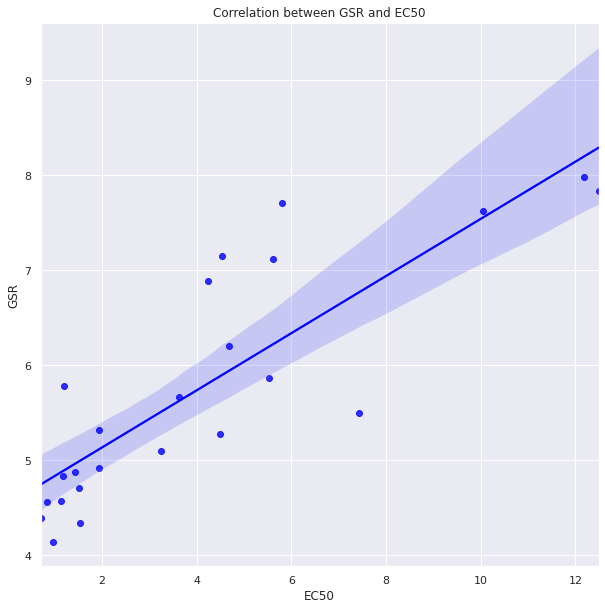

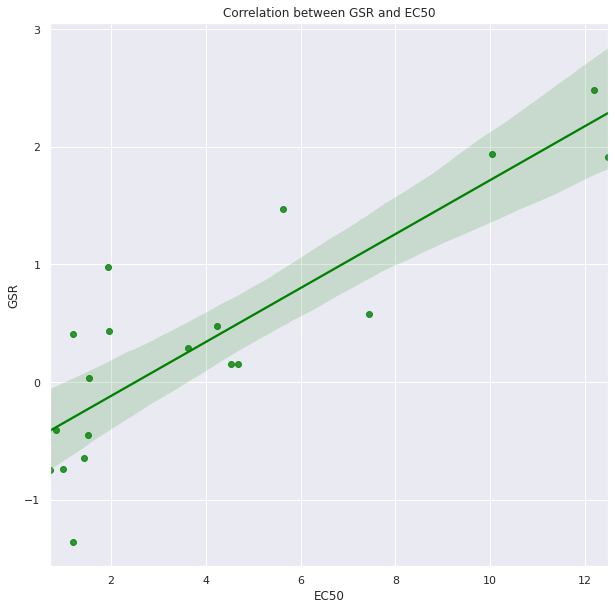

In [6]:
a = widgets.Text(
    value='',
    placeholder='Type a gene name',
    description='Gene:',
    disabled=False
)


run_button = widgets.Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

out = widgets.Output()
display(out)

def on_run_button_clicked(b):
    with out:
        clear_output()
        print(str(a.value).upper() + " expression:")
        s =  NSCLC_expression(str(a.value).upper())
        print(str(a.value).upper() + " protein expression:")
        p = NSCLC_Protein(str(a.value).upper())

run_button.on_click(on_run_button_clicked)
display(a, run_button)